In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup 
import requests
import time
import unidecode as unidec
import json
import pickle
import re
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys

In [94]:
glassdoor_url = 'https://www.glassdoor.com/index.htm'

indeed_urls = {"SG":"https://www.indeed.com.sg/jobs",
       "US":"https://www.indeed.com/jobs",
       "MY":"https://www.indeed.com.my/jobs",
       "UK":"https://www.indeed.co.uk/jobs",
       "AUS":"https://au.indeed.com/jobs",
       "CAN":"https://ca.indeed.com/jobs",
        }

In [3]:
target_cities= {'US':['New York', 'Chicago', 'San Francisco', 'Austin', 'Seattle','Los Angeles', 'Philadelphia', 
                      'Atlanta', 'Dallas','Houston'],
                'SG':["Singapore"],
                'MY':['Kuala Lumpur'],
                "UK":["London", "Newcastle","Sheffield","Bristol","Manchester","Glasgow","Edinburgh","Birmingham","Liverpool",
                      "Aberdeen","Nottingham","Belfast","Cardiff","Cambridge","Oxford"],
                "GEM":["Berlin","Hamburg","Frankfurt am Main"],
                "AUS" :["Sydney","Melbourne","Brisbane","Perth"],
                "CAN" :["Toronto","Montreal","Vancouver","Quebec"]}
roles = ['data scientist', 'data analyst']

In [45]:
def indeed_scraper(job_titles, country_url, city, entries=50):
    
    companies_df,jd_df,salaries_df,locations_df,jobs_df = [],[],[],[],[]
    
    def job_title(data): 
        jobs = []
        for div in data.find_all(name='div', attrs={'class':'row'}):
            for a in div.find_all(name='a', attrs={'data-tn-element':'jobTitle'}):
                jobs.append(a['title'])
        return jobs
    def company(soup): 
        companies = []
        for div in soup.find_all('div', attrs={'class':'row'}):
            company = div.find_all('span', attrs={'class':'company'})
            if len(company) > 0:
                for b in company:
                    companies.append(b.text.strip())
            else:
                sec_try = div.find_all('span', attrs={'class':'result-link-source'})
                for span in sec_try:
                    companies.append(span.text.strip())
        return companies
 
    def location(data): 
        locations = []
        spans = data.findAll('span', attrs={'class': 'location'})
        for span in spans:
            locations.append(span.text)
        return locations
    def salary(data): 
        salaries = []
        
        for div in soup.find_all(name='div', attrs={'class':'row'}):
            try:
                salaries.append(div.find('nobr').text)
            except:
                try:
                    div_two = div.find(name='div', attrs={'class':'sjcl'})
                    div_three = div_two.find('div')
                    salaries.append(div_three.text.strip())
                except:
                    salaries.append('None')
        return salaries
    def jd(data): 
        jd = []
        spans = data.findAll('span', attrs={'class': 'summary'})
        for span in spans:
            jd.append(span.text.strip())
        return jd
    
    for job in job_titles:
        job = str(job).split()
        for cit in city:
            for entry in range(0, entries, 10):

                url = country_url %(job[0],job[1]) + '&l='+cit+ '&start=%s' %entry
                response = requests.get(url)
                html = response.text
                soup = BeautifulSoup(html, 'html.parser')
                time.sleep(5)

                jobs_df.extend(job_title(soup))
                companies_df.extend(company(soup))
                locations_df.extend(location(soup))
                salaries_df.extend(salary(soup))
                jd_df.extend(jd(soup))
                print "Job role: ", len(job_title(soup)), '\n', job
                print "=========================================================="
                print job_title(soup)
                print company(soup)
                print location(soup)
                print salary(soup)

            
            
    indeed = pd.DataFrame(data = zip(jobs_df,companies_df,locations_df,salaries_df,jd_df), 
                          columns = ['job_title','company','location','salary','jd'])
    
    indeed.to_pickle('CA_df1.pickle')
    
    return indeed

In [ ]:
def gd_login(driver, username, password):
    try:
        sign_in = driver.find_element(By.CLASS_NAME,'sign-in')
        sign_in.click()
        time.sleep(3)
        sign_in = driver.find_element(By.ID,'LoginModule-GPlusBtnSignIn')
        sign_in.click()
        time.sleep(3)
        main = driver.current_window_handle
        for handle in driver.window_handles:
            if handle != main:
                main = handle
        driver.switch_to.window(main)
        time.sleep(2)
        email = driver.find_element(By.NAME,"identifier")
        email.click()
        email.send_keys(username)
        email = driver.find_element(By.CLASS_NAME,'CwaK9')
        email.click()
        time.sleep(3)
        passwd = driver.find_element(By.NAME,"password")
        passwd.click()
        passwd.send_keys(password)
        passwd = driver.find_element(By.CLASS_NAME,'CwaK9')
        passwd.click()
        time.sleep(3)
        passwd = driver.find_element(By.CLASS_NAME,'CwaK9')
        passwd.click()
        time.sleep(3)
        time.sleep(10)
        driver.switch_to.window(original_window)
        time.sleep(3)
    except TimeoutException:
        print("TimeoutException! Username/password field or login button not found on glassdoor.com")

In [ ]:
def gd_search_sal(driver):
    search = driver.find_element(By.CLASS_NAME,'context-choice-list')
    search.click()
    time.sleep(5)
    search = driver.find_element(By.CLASS_NAME,'salaries')
    search.click()
    time.sleep(3)
def gd_search_role(driver, city, title):
    search = driver.find_element(By.NAME,'sc.keyword')
    search.click()
    search.clear()
    search.send_keys(title)
    time.sleep(3)
    search = driver.find_element(By.ID,'LocationSearch')
    search.click()
    search.clear()
    search.send_keys(city)
    time.sleep(3)
    search = driver.find_element(By.CLASS_NAME, 'gd-btn-mkt')
    search.click()
    time.sleep(3)
    try:
        search = driver.find_element(By.CLASS_NAME,'mfp-close')
        search.click()
    except:
        pass

In [ ]:
def gd_create_df (driver,city, pages):
    df = pd.DataFrame()
    current_url = driver.current_url
    print current_url
    for i in range(pages):
        print i
        if i == 0:
            new_url = current_url
        else:
            new_url = current_url+'_IP%s.htm'%i
        driver.get(new_url)
        time.sleep(4)
        HTML = driver.page_source
        soup = BeautifulSoup(HTML, "html.parser")
        lastpage = soup.find_all('li',attrs = {'class':'page last'})
        print lastpage
        if len(lastpage) ==0:
            break
        else:
            job,companies,salaries = [],[],[]

            table = soup.find_all('div', attrs = {'class':'tbl'})
            title = soup.find_all('span', attrs = {'class':'strong noMargVert'})
            for i in title:
                job.append(i.text)
            company = soup.find_all('div', attrs = {'class':'small'})
            for i in company:
                companies.append(i.text)
            salary = soup.find_all('div', attrs = {'class':'hideDesk meanPay padTop aboveRangeBar'})
            for i in salary:
                salaries.append(i.text)


        df = pd.DataFrame(data = zip(job,companies,salaries), columns = ['job_title','companies','salaries'])
        df['location'] = city

    return df
    

<div class = "alert alert-block alert-info"> **Scraping Indeed data** </div>

In [46]:
indeed_df = indeed_scraper(['data scientist', 'data analyst', 'data engineer', 'data analytics',
               'business intelligence', 'big data','machine learning'], country_url=indeed_urls[1],city = cities[0:3],entries=800,)


AttributeError: ResultSet object has no attribute 'find_all'. You're probably treating a list of items like a single item. Did you call find_all() when you meant to call find()?

<div class = " alert alert-block alert-info"> ** Scraping Glassdoor **</div>

In [ ]:
driver = webdriver.Chrome(executable_path = "./chromedriver/chromedriver")
driver.get('https://www.glassdoor.com/index.htm')
original_window = driver.current_window_handle

In [ ]:
gd_login(driver, username, password)         # Errors may pop up, but it's not a big deal. Can still carry on

In [ ]:
if driver.current_window_handle!= original_window:
    driver.switch_to.window(original_window)
driver.current_url

In [ ]:
gd_search_sal(driver)
time.sleep(2)

In [ ]:
original_url = driver.current_url
aus_df = pd.DataFrame()
city_df = pd.DataFrame()
#for key in target_cities.keys():
for city in target_cities['UK']:
    
    for role in roles: 
        gd_search_role(driver, city, title=role)
        time.sleep(4)
        city_df = pd.concat ([city_df,gd_create_df(driver=driver,city = city, pages = 50)],axis =0)
        driver.get(original_url)
        time.sleep(4)
    print 'Finished scraping: ', city

In [17]:
indeed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8123 entries, 0 to 8122
Data columns (total 5 columns):
job_title    8123 non-null object
company      8123 non-null object
location     8123 non-null object
salary       8123 non-null object
jd           8123 non-null object
dtypes: object(5)
memory usage: 317.4+ KB


In [18]:
indeed_df.describe()

,job_title,company,location,salary,jd
count,8123,8123,8123,8123,8123
unique,2584,1182,54,3,3441
top,Data Scientist,Accenture,Singapore,None,"E.g.Big Data – Hadoop, Hive, Map Reduce, Tradi..."
freq,369,659,7278,7984,162


In [63]:
indeed_df[indeed_df.duplicated].shape

(4363, 5)

<div class = " alert alert-block alert-warning"> ** Indeed gave more results. Glassdoor returned very few results. Hence just use Indeed data. **</div>

In [261]:
consol_pickle = pd.read_pickle('Consolidate.pickle')
consol_pickle.reset_index(inplace = True)

In [431]:
consol_pickle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4343 entries, 0 to 4342
Data columns (total 9 columns):
index          4343 non-null int64
company        4335 non-null object
country        4343 non-null object
description    4343 non-null object
location       4343 non-null object
review         2040 non-null object
salary         4343 non-null object
star           2040 non-null object
title          4343 non-null object
dtypes: int64(1), object(8)
memory usage: 305.4+ KB


In [432]:
consol_pickle.head()

,index,company,country,description,location,review,salary,star,title
0,10,UMeKang,Singapore,"Use all available data, undertaking data disco...",Singapore,None,"$9,000 - $11,000 a month",None,Data Scientist
1,3,Cresco Data Pte Ltd,Singapore,Data Scientist Duties:. We are looking for a D...,Tanjong Pagar,None,"$3,500 - $4,500 a month",None,Data Scientist
2,8,iKas International (Asia) Pte Ltd,Singapore,"Using data modeling, linear regression, statis...",Singapore,None,"$7,000 - $9,000 a month",None,Data Scientist
3,6,Vault Dragon,Singapore,Assist the Data Scientist in deploying Machine...,Singapore,None,"$4,000 - $6,000 a month",None,Data Engineer
4,5,TSA Solutions,Singapore,Data Scientist - Summary*. Bachelor in degree ...,Pasir Panjang,None,"$4,200 a month",None,Data Scientist


In [76]:
print consol_pickle[consol_pickle.salary.str.contains('year')].shape
print consol_pickle[consol_pickle.salary.str.contains('month')].shape
print consol_pickle[consol_pickle.salary.str.contains('day')].shape
print consol_pickle[consol_pickle.salary.str.contains('week')].shape
print consol_pickle[consol_pickle.salary.str.contains('hour')].shape

(3460, 9)
(203, 9)
(287, 9)
(52, 9)
(341, 9)


In [262]:
#Drop day and hour and Malaysia samples
d = consol_pickle[consol_pickle.salary.str.contains('day')].index
h = consol_pickle[consol_pickle.salary.str.contains('hour')].index
m = consol_pickle[consol_pickle.country.str.contains('Malaysia')].index
consol_pickle.drop(d, axis = 0, inplace = True)
consol_pickle.drop(h, axis = 0, inplace = True)
consol_pickle.drop(m, axis = 0, inplace = True)
consol_pickle.reset_index(inplace=True)

In [263]:
consol_pickle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3698 entries, 0 to 3697
Data columns (total 10 columns):
level_0        3698 non-null int64
index          3698 non-null int64
company        3690 non-null object
country        3698 non-null object
description    3698 non-null object
location       3698 non-null object
review         1673 non-null object
salary         3698 non-null object
star           1673 non-null object
title          3698 non-null object
dtypes: int64(2), object(8)
memory usage: 289.0+ KB


<div class = "alert alert-block alert-info"> ** Data cleaning** </div>

In [264]:
#To standardize all salary to per year basis

consol_pickle['multiplier'] = 0
consol_pickle['by_mth'] = 0
consol_pickle['by_yr'] = 0
consol_pickle['by_wk'] = 0

consol_pickle.loc[consol_pickle.salary.str.contains('month'),'by_mth'] = 1
consol_pickle.loc[consol_pickle.salary.str.contains('year'),'by_yr'] = 1
consol_pickle.loc[consol_pickle.salary.str.contains('week'),'by_wk'] = 1
consol_pickle.loc[consol_pickle.by_mth==1,'multiplier'] = 12
consol_pickle.loc[consol_pickle.by_yr==1,'multiplier'] = 1
consol_pickle.loc[consol_pickle.by_wk==1,'multiplier'] = 52
consol_pickle.loc[consol_pickle.salary.str.contains('month') & consol_pickle.country.str.contains('Singapore'),'multiplier'] = 13

In [265]:
#Remove special characters and currency symbols

import re
r = re.compile(u'£')
consol_pickle.loc[:,'salary'] = consol_pickle.salary.str.replace(' a year', '')
consol_pickle.loc[:,'salary'] = consol_pickle.salary.str.replace(' a month', '')
consol_pickle.loc[:,'salary'] = consol_pickle.salary.str.replace(' a week', '')
consol_pickle.loc[:,'salary'] = consol_pickle.salary.str.replace(' a day', '')
consol_pickle.loc[:,'salary'] = consol_pickle.salary.str.replace(' an hour', '')
consol_pickle.loc[:,'salary'] = consol_pickle.salary.str.replace('$', '')
consol_pickle.loc[:,'salary'] = consol_pickle.salary.str.replace('£', '')
consol_pickle.loc[:,'salary'] = consol_pickle.salary.str.replace('RM', '')
consol_pickle.loc[:,'salary'] = consol_pickle.salary.str.replace(r, '')
consol_pickle.loc[:,'salary'] = consol_pickle.salary.str.replace(',', '')
consol_pickle.loc[:,'salary'] = consol_pickle.salary.str.replace('Estimated salary: ','')

In [266]:
#Creating max, min and mean salary columns

consol_pickle['split'] = 0
consol_pickle['min_sal'] =0
consol_pickle['max_sal'] =0
consol_pickle['mean_sal'] =0

split = consol_pickle.salary.str.split(' - ').tolist()
min_ = [i[0] for i in split]
max_ = [i[1] if len(i)>1 else i[0] for i in split]
for i in range(len(max_)):
    max_[i] = float(str(max_[i]))
    min_[i] = float(str(min_[i]))
for i in range(len(max_)):
    if type(min_[i]) != float:
        print i,  'not float'
consol_pickle.loc[:,'min_sal']= min_
consol_pickle.loc[:,'max_sal']= max_
consol_pickle['min_sal'] = pd.to_numeric(consol_pickle['min_sal'])*consol_pickle['multiplier']
consol_pickle['max_sal'] = pd.to_numeric(consol_pickle['max_sal'])*consol_pickle['multiplier']
consol_pickle['mean_sal']= (consol_pickle['max_sal'] + consol_pickle['min_sal'])/2.0

#Can drop the unnecessary columns now
consol_pickle.drop(['by_yr','by_mth','by_wk','split'], axis = 1, inplace = True)

In [268]:
# To convert all salary to USD

from forex_python.converter import CurrencyRates
c = CurrencyRates()
country_cur = {'Singapore':'SGD','United Kingdom':'GBP','Australia':'AUD',\
               'United States':'USD','Malaysia':'MYR','Canada':'CAD'}
conv = c.get_rates('USD')

for i in range (len (consol_pickle)):
    if consol_pickle.loc[i,'country'] == 'United States':
        pass
    else:
        consol_pickle.loc[i,'min_sal'] =  consol_pickle['min_sal'][i]/conv[country_cur[consol_pickle.country.values[i]]]
        consol_pickle.loc[i,'max_sal'] =  consol_pickle['max_sal'][i]/conv[country_cur[consol_pickle.country.values[i]]]
        consol_pickle.loc[i,'mean_sal'] =  consol_pickle['mean_sal'][i]/conv[country_cur[consol_pickle.country.values[i]]]
        
consol_pickle.rename(columns = {'mean_sal':'mean_sal_USDpy','min_sal':'min_sal_USDpy','max_sal':'max_sal_USDpy'},inplace = True)

In [270]:
#consol_pickle.to_pickle('indeed_cleanedsal.pickle')
consol = pd.read_pickle('indeed_cleanedsal.pickle')

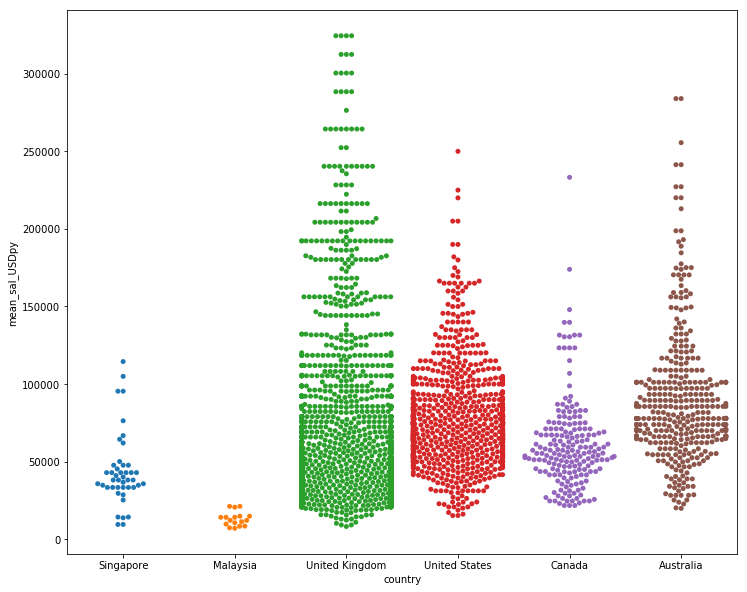

In [38]:
plt.subplots(figsize = (12,10))
sns.swarmplot(x =consol["country"], y=consol["mean_sal_USDpy"], data = consol)
plt.show()

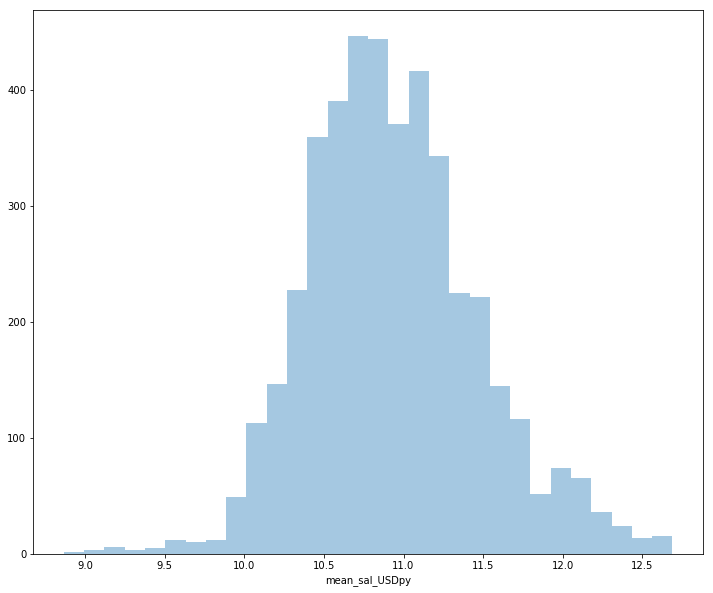

In [44]:
plt.subplots(figsize = (12,10))
sns.distplot(np.log(consol["mean_sal_USDpy"]), bins = 30, kde=False)
plt.xlabel('Log Mean Salary')
plt.show()

In [88]:
consol.head()

,level_0,index,company,country,description,location,review,salary,star,title,multiplier,min_sal_USDpy,max_sal_USDpy,mean_sal_USDpy
0,0,10,UMeKang,Singapore,"Use all available data, undertaking data disco...",Singapore,None,9000 - 11000,None,Data Scientist,13,85877.862595,104961.832061,95419.847328
1,1,3,Cresco Data Pte Ltd,Singapore,Data Scientist Duties:. We are looking for a D...,Tanjong Pagar,None,3500 - 4500,None,Data Scientist,13,33396.946565,42938.931298,38167.938931
2,2,8,iKas International (Asia) Pte Ltd,Singapore,"Using data modeling, linear regression, statis...",Singapore,None,7000 - 9000,None,Data Scientist,13,66793.893130,85877.862595,76335.877863
3,3,6,Vault Dragon,Singapore,Assist the Data Scientist in deploying Machine...,Singapore,None,4000 - 6000,None,Data Engineer,13,38167.938931,57251.908397,47709.923664
4,4,5,TSA Solutions,Singapore,Data Scientist - Summary*. Bachelor in degree ...,Pasir Panjang,None,4200,None,Data Scientist,13,40076.335878,40076.335878,40076.335878


In [271]:
consol.location.unique()

array([u'Singapore', u'Tanjong Pagar', u'Pasir Panjang', u'Ang Mo Kio',
       u'Central Business District', u'Kallang', u'Jurong East', u'Tuas',
       u'Serangoon', u'London', u'South Kensington', u'Merton', u'Bedford',
       u'Southampton', u'Berkshire', u'Fareham PO15', u'Woking',
       u'Westerham', u'Norwich', u'Shoreditch', u'London SW1A', u'Horsham',
       u'London EC3A', u'London E1', u'High Street Kensington Station',
       u'Colchester', u'Basingstoke', u'South East',
       u'Newcastle upon Tyne', u'Leeds', u'York', u'Lancashire',
       u'North Yorkshire', u'North East', u'Ripon', u'Edinburgh',
       u'Teesside', u'Bradford', u'Sunderland', u'Brighouse', u'Gateshead',
       u'Halifax', u'Barrow-In-Furness', u'Boston Spa', u'Leeds LS1',
       u'Shipley', u'East Riding of Yorkshire', u'Wakefield', u'Pudsey',
       u'North West', u'Colne', u'Pontefract',
       u'City of Kingston upon Hull', u'Durham', u'Yorkshire',
       u'Harrogate', u'Humberside', u'Leyland', u'Il

In [273]:
#Consolidating the locations into major cities

consol.loc[consol.country.str.contains('United Kingdom'),'location'] = \
consol[consol.country.str.contains('United Kingdom')].location.astype(str)


sg = ['Tanjong Pagar', 'Pasir Panjang', 'Ang Mo Kio','Central Business District', 'Kallang', 'Jurong East', 'Tuas',
       'Serangoon']

lon = ['Kensington','Merton','Berkshire','Woking','Westerham','Shoreditch','London','Basingstoke','South East','College',
       'Milton Keynes','Cobham','Reading','Surrey','Feltham','Guildford','Kingston upon Thames','Guam',
      'Weybridge','Slough','Bracknell','Leatherhead','Luton','Uxbridge','Farnborough','Maidenhead',
      'Middlesex','Isleworth','Feltham TW13','High Wycombe','Aylesbury HP22','Teddington','New Haw','Camden',
      'West End','Brentford','Hammersmith','South Mimms','Hertford','Hill','Farnham','Staines-upon-Thames','Barnet',
      'County','Welwyn Garden City','Marlow','Redhill','Kent','Hatfield','Uckfield','Essex','Stevenage',"Liverpool Street Station","Barbican","East Anglia","Hitchin","Market","Watford","Harlow","Thames Valley",
       "Basingstoke","St Albans","Margate","Bisham","Canterbury","Chelmsford","Hemel Hempstead",
       "Ashford","Stratfield Mortimer","Croydon","Sutton","Brighton and Hove","Grays","Haywards Heath","Letchworth",
      'Oxford','Newport Pagnell','Didcot','Haddenham','Ardley',"Henley on Thames","Abingdon","Chipping Campden",
       "Kidlington",'Thame','Warwick',"Witney","Buckinghamshire","Wallingford","Leamington Spa","Cheltenham","Farringdon"]

sth = ['Southampton','Fareham','Horsham','Portsmouth','Salisbury','West Sussex','Salisbury','Havant','Bournemouth',
      'Chichester','Newbury','Winchester',"Chandler's Ford",'Eastleigh','Brighton',"Plymouth","Dorchester","Torquay",
       "Hove","Saint Ives","Porton Down",'Kingston upon Hull','Wimborne']

new = ['Newcastle upon Tyne','Yorkshire','Teesside','Sunderland','Gateshead','Durham','Stockton-on-Tees','Stockton-on-Tees TS18'
       'Houghton le Spring','Cramlington','Sedgefield','Peterlee','Middlesbrough','Newton Aycliffe','Cumbria',
      'Tyne and Wear','Birtley','Nebraska','Penrith',"Sand Hutton","Full Sutton",'Washington'] 

manc =['Lancashire','Ripon','Bradford','Brighouse','Halifax','Pudsey','Colne','Harrogate','Leyland','Ilkley',
       'Huddersfield','Barnoldswick','Baildon','Burnley','Bury','High Bentham','Blackburn','Manchester M60',
      'Warrington','Liverpool','Trafford','Bolton','Cheshire','Manchester','Chorley','Wilmslow','Cheadle',
      'Stockport','Salford','Jodrell Bank','Lancaster','Skipton','Handforth','Macclesfield','Wilmslow','Accrington',
      "Telford","Crewe","Bangor","Chirk",'Leeds','York','North East','Boston Spa','Shipley','East Riding of Yorkshire','Wakefield',
      'Pontefract','City of Kingston upon Hull','Humberside','Barnsley','Willerby','Brough HU15','Howden',
      'Newcastle-under-Lyme','Doncaster','Hampshire','Beverley','Mansfield','Doncaster','Lincoln','Scunthorpe',
      'Gainsborough','Castleford','Keighley','Barrow-In-Furness','Preston','Blackpool','Fleetwood','Runcorn','Chester',
       'Golborne','Flintshire','Wirral','Bethesda','Oswestry',"Birkenhead","Knowsley","Bootle",'North West']

scot =['Glasgow','Fife','Dundee','Tranent','Balerno','Dunbartonshire','Stirling','North Lanarkshire','Montrose',
      'Larbert','Montrose','St. Andrews','Edinburgh' ,'Aberdeen','Grampian Region',"Inverness",'Dunfermline']

birm =['Nottingham','Northampton','Leicester','Glamorgan','Solihull','Sutton Coldfield B75',
      'Atherstone','Derby','Birmingham','Walsall','East Midlands','Burton-On-Trent','Coventry','Stoke-on-Trent',
      'Kingswinford','Worcester','Stafford','Wolverhampton','Loughborough','Walsall','Ludlow','Cannock','Kidderminster',
      'Stratford-upon-Avon','Oldbury','Hindlip','Cirencester','Worcestershire',"Waltham on the Wolds","Tamworth",
       "Chesterfield",'Redditch',"Kettering","Stoneleigh","Bromsgrove"]

ire = ['Belfast',"Newry","Coleraine","Douglas","Strabane","Cookstown","Antrim"]

ips = ['Norwich','Eye','Cambridge','Bedford','Colchester','Peterborough','Hinxton','Saffron Walden','Spalding','Ely',
       'Milton','Lowestoft','Suffolk','Huntingdon',"Royston","Harston","Thetford","Wellingborough","Sharnbrook",
       "Rushden","Kedleston","Shrewsbury"] 

card =['West Midlands','Swindon','Swansea','Cardiff','North Tawton','Cwmbran','Somerset','Bath','Newport',
       'Chippenham','Bridgend','Stoke Gifford','Port Talbot','Warminster','Glascoed','Stonehouse','Bridgwater',
       'Plymouth','Westerleigh',"Bristol","Gloucester","Devizes","Poole","Wiltshire","South West","Wales"
        "Wimborne","Abergavenny","Exeter"]

canada = {'QC':'Montreal', 'ON':'Toronto', 'BC':'Vancouver'}
aus = {'VIC':'Melbourne', 'NSW':'Sydney', 'QLD':'Brisbane','WA':'Perth'}
us = {"AL": "Alabama","AK": "Alaska","AS": "American Samoa","AZ": "Arizona","AR": "Arkansas","CA": "California",
"CO": "Colorado","CT": "Connecticut","DE": "Delaware","DC": "District Of Columbia","FM": "Federated States Of Micronesia",
"FL": "Florida","GA": "Georgia","GU": "Guam","HI": "Hawaii","ID": "Idaho","IL": "Illinois","IN": "Indiana","IA": "Iowa",
"KS": "Kansas","KY": "Kentucky","LA": "Louisiana","ME": "Maine","MH": "Marshall Islands","MD": "Maryland","MA": "Massachusetts",
"MI": "Michigan","MN": "Minnesota","MS": "Mississippi","MO": "Missouri","MT": "Montana","NE": "Nebraska","NV": "Nevada",
"NH": "New Hampshire","NJ": "New Jersey","NM": "New Mexico","NY": "New York","NC": "North Carolina","ND": "North Dakota",
"MP": "Northern Mariana Islands","OH": "Ohio","OK": "Oklahoma","OR": "Oregon","PW": "Palau","PA": "Pennsylvania",
"PR": "Puerto Rico","RI": "Rhode Island","SC": "South Carolina","SD": "South Dakota","TN": "Tennessee","TX": "Texas",
"UT": "Utah","VT": "Vermont","VI": "Virgin Islands","VA": "Virginia","WA": "Washington","WV": "West Virginia",
"WI": "Wisconsin","WY": "Wyoming"}

In [286]:
# Clean up the text in the location column

for key in lon:
    consol.loc[consol.location.str.contains(key),'location'] = 'London'
for key in sth:
    consol.loc[consol.location.str.contains(key),'location'] = 'Southampton'

for key in new:
    consol.loc[consol.location.str.contains(key),'location'] = 'Newcastle'

for key in manc:
    consol.loc[consol.location.str.contains(key),'location'] = 'Manchester'

for key in scot:
    consol.loc[consol.location.str.contains(key),'location'] = 'Scotland'

for key in birm:
    consol.loc[consol.location.str.contains(key),'location'] = 'Birmingham'

for key in ire:
    consol.loc[consol.location.str.contains(key),'location'] = 'Ireland'

for key in ips:
    consol.loc[consol.location.str.contains(key),'location'] = 'Ipswich'
for key in card:
    consol.loc[consol.location.str.contains(key),'location'] = 'Cardiff'
    
for key in us.keys():
    consol.loc[consol.location.str.contains(key),'location'] = us[key]

for key in canada.keys():
    consol.loc[consol.location.str.contains(key),'location'] = canada[key]
for key in aus.keys():
    consol.loc[consol.location.str.contains(key),'location'] = aus[key]
for key in sg:
    consol.loc[consol.location.str.contains(key),'location'] = 'Singapore' 


consol.drop(consol[consol.location.str.contains('Stockton-On-Tees TS18')].index, axis=0, inplace = True)
consol.loc[consol.location.str.contains('Remote'), 'location'] = 'California'
consol.loc[consol.location.str.contains('Houghton le Spring'), 'location'] = 'Newcastle'
consol.location = consol.location.astype(str)
consol.rename(columns={'location':'city'},inplace = True)

In [170]:
consol[consol.country.str.contains('United Kingdom')].location.unique()


45

In [288]:
consol.to_pickle('indeed_cleanedsal.pickle')
#consol = pd.read_pickle('indeed_cleanedsal.pickle')


In [455]:
 consol.city.unique()

array(['Singapore', 'London', 'Ipswich', 'Southampton', 'Newcastle',
       'Manchester', 'Scotland', 'Sheffield', 'Cardiff', 'Birmingham',
       'Ireland', 'Wales', 'California', 'Illinois', 'Wisconsin', 'Texas',
       'Maryland', 'Pennsylvania', 'New Jersey', 'Georgia', 'Toronto',
       'Montreal', 'Vancouver', 'Sydney', 'Virgin Islands', 'Brisbane'], dtype=object)

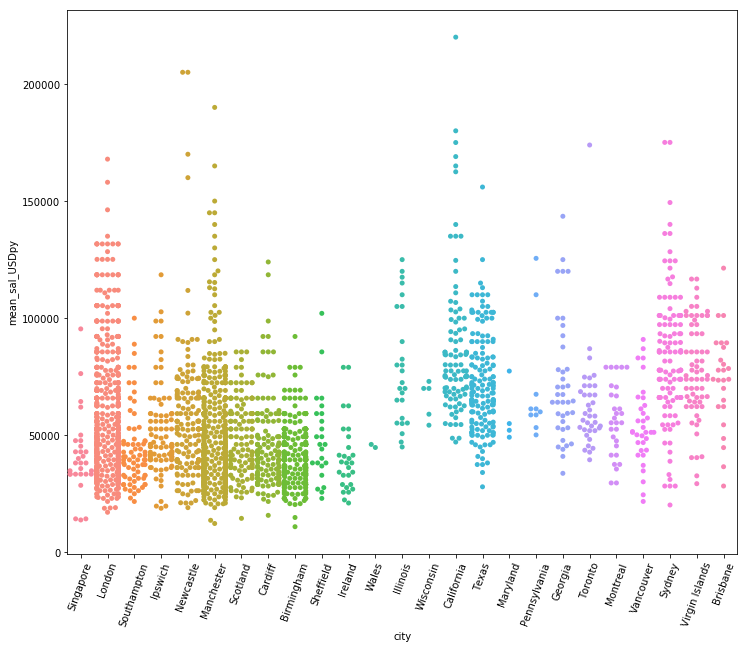

In [17]:
plt.subplots(figsize = (12,10))
sns.swarmplot(x =consol["city"], y=consol["mean_sal_USDpy"], data = consol)
plt.xticks(rotation = 70)
plt.show()

In [281]:
consol.title.value_counts()

Data Analyst                                                                             129
Data Scientist                                                                           107
Business Analyst                                                                          64
Senior Data Scientist                                                                     24
Analyst                                                                                   18
Financial Analyst                                                                         16
Finance Analyst                                                                           16
Insight Analyst                                                                           14
Reporting Analyst                                                                         13
Marketing Analyst                                                                         12
Data Engineer                                                         

In [214]:
consol.loc[:,'title'] = consol.title.str.lower()
consol[consol.title.str.contains(r'scientist')]['title'].value_counts()

data scientist                                                                                          109
senior data scientist                                                                                    24
lead data scientist                                                                                      10
research scientist                                                                                        6
senior research scientist                                                                                 4
bio-assay meth. dev. scientist, yorkshire                                                                 3
data scientist / software developer                                                                       3
principal data scientist                                                                                  3
product development scientist                                                                             3
fraud analytics data scienti

In [335]:
consol.description = consol.description.astype('unicode')
consol.description = consol.description.str.lower()
consol.company = consol.company.astype('unicode')
consol.company = consol.company.str.lower()

In [2]:
scianal = pd.read_pickle('sciandanalyst.pickle')

scianal.rename(columns= {'location':'city'},inplace = True)
scianal.description = scianal.description.astype('unicode')
scianal.description = scianal.description.str.lower()
scianal.company = scianal.company.astype('unicode')
scianal.company = scianal.company.str.lower()
scianal.country = scianal.country.astype('unicode')
scianal.country = scianal.country.str.lower()

<div class = " alert alert-block alert-info"> ** Question 1 **
<br><br>
Use Job Title, Company and Job Description to Regress Salary</div>

In [167]:
#####  Lasso pipeline  ######

def lass (df, target):
    from sklearn.linear_model import LassoCV
    from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
    from sklearn.pipeline import make_pipeline
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import LabelEncoder,OneHotEncoder
    
    #Create Train Test Splits
    
    le1 = LabelEncoder()
    le2 = LabelEncoder()
    ohe = OneHotEncoder()
    tfidf_vec1 = TfidfVectorizer(sublinear_tf=True,max_df=0.8,max_features=3000, ngram_range = (1,3), stop_words='english')
    tfidf_vec2 = TfidfVectorizer(sublinear_tf=True,max_df=0.8,max_features=3000, ngram_range = (1,3), stop_words='english')
    tfidf_vec3 = TfidfVectorizer(sublinear_tf=True,max_df=0.7,max_features=4000, ngram_range = (1,4), stop_words='english')
    
    Xcit = ohe.fit_transform(le1.fit_transform(df.city).reshape(-1,1))
    Xcountry = ohe.fit_transform(le2.fit_transform(df.country).reshape(-1,1))
    Xt = tfidf_vec1.fit_transform(df.title)
    Xd = tfidf_vec2.fit_transform(df.description)
   
    Xcitdf =pd.DataFrame(data=Xcit.toarray(),columns = le1.classes_.tolist())
    Xcountrydf = pd.DataFrame(data=Xcountry.toarray(),columns = le2.classes_.tolist())
    Xtdf = pd.DataFrame(data = Xt.toarray(), columns = tfidf_vec1.get_feature_names())
    Xddf = pd.DataFrame(data = Xd.toarray(), columns = tfidf_vec2.get_feature_names())
    
    y = np.log(df.mean_sal_USDpy.values)
    X = pd.concat([Xcitdf,Xcountrydf,Xtdf,Xddf], axis = 1)


    Xtr,Xte, ytr,yte = train_test_split(X,y, test_size= 0.3,shuffle=True)
    
    las1 = LassoCV(alphas=np.arange(0.001, 0.2, 0.05), cv=5, random_state=179,verbose = True)

    las1.fit(Xtr,ytr)
    ypred_las= las1.predict(Xte)

    print 'Training set score: ', las1.score(Xtr,ytr)
    print 'Test set score: ',las1.score(Xte,yte)
    imp = pd.DataFrame(data = zip(Xtr.columns,las.coef_),columns= ['Features','Coeffs']).sort_values('Coeffs',ascending = False)
    print imp.head(20)

    sns.regplot(x= yte.ravel(), y = ypred_las.ravel()).set_title('Features important to salary')
   
    plt.show()
    return imp

....................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.8s finished


Job title - Training set score:  0.547767284444
Job title - Test set score:  0.507889146909
                         Features    Coeffs
992                       digital  0.754187
2522                scientist big  0.548278
2                      California  0.445283
1662             modelling credit  0.408620
18                         Sydney  0.390506
2194                       python  0.365297
22                 Virgin Islands  0.289329
19                          Texas  0.243713
5                        Illinois  0.210137
1                        Brisbane  0.187055
2088                  procurement  0.166527
2554    scientist graduate scheme  0.165961
4                         Georgia  0.158571
671      business systems analyst  0.131855
2832  statistics vital statistics  0.115156
670              business systems  0.099001
2161            project financial  0.092476
13                   Pennsylvania  0.054472
1669                    molecular  0.053421
1733         nav business an

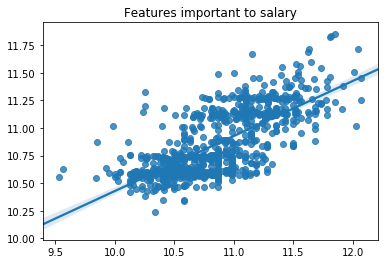

,Features,Coeffs
992,digital,7.541868e-01
2522,scientist big,5.482783e-01
2,California,4.452833e-01
1662,modelling credit,4.086204e-01
18,Sydney,3.905056e-01
2194,python,3.652969e-01
22,Virgin Islands,2.893292e-01
19,Texas,2.437135e-01
5,Illinois,2.101369e-01
1,Brisbane,1.870554e-01


In [169]:
lass(scianal,'mean_sal_USDpy')

In [201]:
######  Random Forest  #######

def dec_tree(df,target):
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
    from sklearn.pipeline import make_pipeline
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import LabelEncoder,OneHotEncoder
    
    #Create Train Test Splits
    
    le1 = LabelEncoder()
    le2 = LabelEncoder()
    ohe = OneHotEncoder()
    tfidf_vec1 = TfidfVectorizer(sublinear_tf=True,max_df=0.8,max_features=3000, ngram_range = (1,3), stop_words='english')
    tfidf_vec2 = TfidfVectorizer(sublinear_tf=True,max_df=0.8,max_features=3000, ngram_range = (1,4), stop_words='english')
    tfidf_vec3 = TfidfVectorizer(sublinear_tf=True,max_df=0.6,max_features=4000, ngram_range = (1,4), stop_words='english')
    
    Xcit = ohe.fit_transform(le1.fit_transform(df.city).reshape(-1,1))
    Xcountry = ohe.fit_transform(le2.fit_transform(df.country).reshape(-1,1))
    Xt = tfidf_vec1.fit_transform(df.title)
    Xd = tfidf_vec2.fit_transform(df.description)
   
    Xcitdf =pd.DataFrame(data=Xcit.toarray(),columns = le1.classes_.tolist())
    Xcountrydf = pd.DataFrame(data=Xcountry.toarray(),columns = le2.classes_.tolist())
    Xtdf = pd.DataFrame(data = Xt.toarray(), columns = tfidf_vec1.get_feature_names())
    Xddf = pd.DataFrame(data = Xd.toarray(), columns = tfidf_vec2.get_feature_names())
    
    y = np.log(df[target].values)
    X = pd.concat([Xcitdf,Xcountrydf,Xtdf,Xddf], axis = 1)
    
    Xtr,Xte, ytr,yte = train_test_split(X,y, test_size= 0.3,shuffle=True)

    dtree1 = DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=30, min_samples_split=2,
                                  min_impurity_split=0.02)
    rf = RandomForestRegressor(n_estimators=20, criterion='mse', max_depth=20, 
                               n_jobs=5, random_state=195, verbose=1)
    ypred_dt = rf.fit(Xtr,ytr).predict(Xte)

    print 'Training set score: ', rf.score(Xtr,ytr)
    print 'Test set score: ',rf.score(Xte,yte)
    
    sns.regplot(x= yte.ravel(), y = ypred_dt.ravel()).set_title('Features important to salary')

    plt.show()
    imp = pd.DataFrame(data = zip(Xtr.columns,rf.feature_importances_), 
                 columns = ['Title','Importance']).sort_values('Importance', ascending = False).nlargest(50,'Importance').reset_index()
    print imp.head(20)
    return imp

[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    4.6s finished
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.0s finished


Training set score:  0.842984204691
Test set score: 

[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.0s finished


 0.635300175236


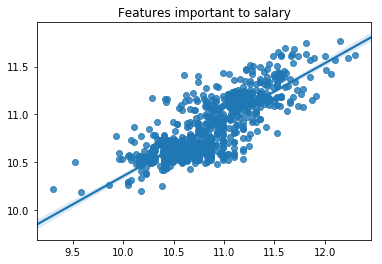

    index             Title  Importance
0      28    united kingdom    0.237846
1     893    data scientist    0.209091
2    2625            senior    0.035824
3    2222      quantitative    0.015068
4      16         Singapore    0.014192
5     207           analyst    0.014006
6    3755              data    0.013931
7       8            London    0.013128
8    1207          graduate    0.012284
9      26            canada    0.011545
10     27         singapore    0.011345
11   3918    data scientist    0.010534
12   1457              lead    0.009188
13   3481          business    0.008071
14    634  business analyst    0.007436
15   5521         scientist    0.006711
16   5595            senior    0.006298
17    493        apprentice    0.005841
18   3180           analyst    0.005387
19   3026              year    0.005001


,index,Title,Importance
0,28,united kingdom,0.237846
1,893,data scientist,0.209091
2,2625,senior,0.035824
3,2222,quantitative,0.015068
4,16,Singapore,0.014192
5,207,analyst,0.014006
6,3755,data,0.013931
7,8,London,0.013128
8,1207,graduate,0.012284
9,26,canada,0.011545


In [202]:
dec_tree(scianal,'mean_sal_USDpy')

<div class = " alert alert-block alert-info"> ** Question 2 **

<br><br>
Use Salary, Company, and Job Description as predictors
<br>
Job title = Data Scientist as Target variable

</div>

In [3]:
scianal['is_DS'] = 0
scianal.loc[scianal.title.str.contains('data scientist'),'is_DS'] = 1

In [6]:
def dec_tree_cls(df,target):
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
    from sklearn.pipeline import make_pipeline
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import classification_report, confusion_matrix
    from sklearn.preprocessing import LabelEncoder,OneHotEncoder
    
    #Create Train Test Splits
    
    le1 = LabelEncoder()
    le2 = LabelEncoder()
    ohe = OneHotEncoder()
    tfidf_vec1 = TfidfVectorizer(sublinear_tf=True,max_df=0.7,max_features=3000, ngram_range = (1,3), stop_words='english')
    
    Xcit = ohe.fit_transform(le1.fit_transform(df.city).reshape(-1,1))
    Xcountry = ohe.fit_transform(le2.fit_transform(df.country).reshape(-1,1))
    Xs = np.log(df.mean_sal_USDpy)
    Xd = tfidf_vec1.fit_transform(df.description)
   
    Xcitdf =pd.DataFrame(data=Xcit.toarray(),columns = le1.classes_.tolist())
    Xcountrydf = pd.DataFrame(data=Xcountry.toarray(),columns = le2.classes_.tolist())
    Xsdf = pd.DataFrame(data = Xs.ravel(), columns = ['Salary'])
    Xddf = pd.DataFrame(data = Xd.toarray(), columns = tfidf_vec1.get_feature_names())
    
    y = df[target].values
    X = pd.concat([Xcitdf,Xcountrydf,Xsdf,Xddf], axis = 1)
    
    Xtr,Xte, ytr,yte = train_test_split(X,y, test_size= 0.3,shuffle=True)
    
    
    dtree1 = DecisionTreeClassifier(criterion='entropy', splitter='best', random_state=35,max_depth=20, min_samples_split=2,class_weight={1:0.9, 0:0.3})
    rf = RandomForestClassifier(n_estimators=80, criterion='entropy', max_depth=35, min_samples_split=2,class_weight={1:0.9, 0:0.2},
                                n_jobs=5, random_state=195, verbose=1,)
                               
    ypred_dtr= dtree1.fit(Xtr,ytr).predict(Xte)

    print 'Training set score: ', dtree1.score(Xtr,ytr)
    print 'Test set score: ',dtree1.score(Xtr,ytr)
    print  confusion_matrix(yte,ypred_dtr, labels=[1,0])
    print  classification_report(yte,ypred_dtr)
    
    imp = pd.DataFrame(data = zip(Xtr.columns,dtree1.tree_.compute_feature_importances()), 
                 columns = ['Title','Importance']).sort_values('Importance', ascending = False).nlargest(50,'Importance').reset_index()
    #rf.feature_importances_
    
    print imp.head(20)
    return imp

In [21]:
dec_tree_cls(scianal,'is_DS')

Training set score:  0.998961578401
Test set score:  0.998961578401
[[ 94  22]
 [  9 701]]
             precision    recall  f1-score   support

          0       0.97      0.99      0.98       710
          1       0.91      0.81      0.86       116

avg / total       0.96      0.96      0.96       826

    index                  Title  Importance
0     933         data scientist    0.460276
1     186                analyst    0.094573
2      30                 Salary    0.066275
3     928           data science    0.052338
4      29          united states    0.023409
5     956        data scientists    0.021545
6    3021                  years    0.017938
7     499               building    0.014809
8     309              analytics    0.014111
9    2249                 python    0.013735
10   1550          investigating    0.012965
11    887            data mining    0.012166
12   1563        job description    0.010761
13   2998                working    0.010259
14   2546          

,index,Title,Importance
0,933,data scientist,0.460276
1,186,analyst,0.094573
2,30,Salary,0.066275
3,928,data science,0.052338
4,29,united states,0.023409
5,956,data scientists,0.021545
6,3021,years,0.017938
7,499,building,0.014809
8,309,analytics,0.014111
9,2249,python,0.013735
